In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Final2022/bionet')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchsummary import summary
import numpy as np
import math
import os
import psutil
print(torch.__version__)
#print(torch.cuda.get_device_name(0))

1.12.1+cu113


In [56]:
from torch._C import float64
Batch_size=100
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.Resize(32),
    #transforms.RandomCrop(32,padding=4), # 数据增广
    #transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
#="/content/drive/My Drive/Final2022/data/ecoset-cifar10/train"
contours_="/content/drive/My Drive/Final2022/data/new224/contours"
contours_inverted_="/content/drive/My Drive/Final2022/data/new224/contours_inverted"
line_drawings_="/content/drive/My Drive/Final2022/data/new224/line_drawings"
line_drawings_inverted_="/content/drive/My Drive/Final2022/data/new224/line_drawings_inverted"
silhouettes_="/content/drive/My Drive/Final2022/data/new224/silhouettes"
silhouettes_inverted_="/content/drive/My Drive/Final2022/data/new224/silhouettes_inverted"

#trainingset1=datasets.ImageFolder(root=a,transform=transform)
#testset1=datasets.ImageFolder(root=b,transform=transform)
'''trainingset1=datasets.ImageFolder(root="../data/Cifar10/train_cifar10",transform=transform)
testset1=datasets.ImageFolder(root="../data/Cifar10/test_cifar10",transform=transform)'''
#trainloader1=DataLoader(trainingset1,batch_size=Batch_size,shuffle=True,num_workers=2)
contours=DataLoader(datasets.ImageFolder(root=contours_,transform=transform),batch_size=Batch_size,shuffle=False,num_workers=1)
contours_inverted=DataLoader(datasets.ImageFolder(root=contours_inverted_,transform=transform),batch_size=Batch_size,shuffle=False,num_workers=1)
line_drawings=DataLoader(datasets.ImageFolder(root=line_drawings_,transform=transform),batch_size=Batch_size,shuffle=False,num_workers=1)
line_drawings_inverted=DataLoader(datasets.ImageFolder(root=line_drawings_inverted_,transform=transform),batch_size=Batch_size,shuffle=False,num_workers=1)
silhouettes=DataLoader(datasets.ImageFolder(root=silhouettes_,transform=transform),batch_size=Batch_size,shuffle=False,num_workers=1)
silhouettes_inverted=DataLoader(datasets.ImageFolder(root=silhouettes_inverted_,transform=transform),batch_size=Batch_size,shuffle=False,num_workers=1)


ImportError: ignored

In [3]:
class BasicBlock(nn.Module):
    """
    对于浅层网络，如ResNet-18/34等，用基本的Block
    基础模块没有压缩,所以expansion=1
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
            nn.Conv2d(out_channels,out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        # 如果输入输出维度不等，则使用1x1卷积层来改变维度
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
    def forward(self, x):
        out = self.features(x)
#         print(out.shape)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out
class Bottleneck(nn.Module):
    """
    对于深层网络，我们使用BottleNeck，论文中提出其拥有近似的计算复杂度，但能节省很多资源
    zip_channels: 压缩后的维数，最后输出的维数是 expansion * zip_channels
    针对ResNet50/101/152的网络结构,主要是因为第三层是第二层的4倍的关系所以expansion=4
    """
    expansion = 4
    
    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.features(x)
#         print(out.shape)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out
class GaborConv2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=False,
        padding_mode="zeros",
    ):
        super().__init__()

        self.is_calculated = False

        self.conv_layer = nn.modules.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
        )
        self.kernel_size = self.conv_layer.kernel_size

        # small addition to avoid division by zero
        self.delta = 1e-3

        # freq, theta, sigma are set up according to S. Meshgini,
        # A. Aghagolzadeh and H. Seyedarabi, "Face recognition using
        # Gabor filter bank, kernel principal component analysis
        # and support vector machine"
        self.freq = nn.Parameter((math.pi / 2) * math.sqrt(2) ** (-torch.randint(0, 5, (out_channels, in_channels))).type(torch.Tensor),requires_grad=True, )
        self.theta = nn.Parameter((math.pi / 8) * torch.randint(0, 8, (out_channels, in_channels)).type(torch.Tensor),requires_grad=True,)
        self.sigma = nn.Parameter(math.pi / self.freq, requires_grad=True)
        self.psi = nn.Parameter(math.pi * torch.rand(out_channels, in_channels), requires_grad=True)
        self.x0 = nn.Parameter(torch.ceil(torch.Tensor([self.kernel_size[0] / 2]))[0], requires_grad=False)
        self.y0 = nn.Parameter(torch.ceil(torch.Tensor([self.kernel_size[1] / 2]))[0], requires_grad=False)
        self.y, self.x = torch.meshgrid(
            [torch.linspace(-self.x0 + 1, self.x0 + 0, self.kernel_size[0]),
             torch.linspace(-self.y0 + 1, self.y0 + 0, self.kernel_size[1]),])
        self.y = nn.Parameter(self.y)
        self.x = nn.Parameter(self.x)
        self.weight = nn.Parameter(torch.empty(self.conv_layer.weight.shape, requires_grad=True),requires_grad=True,)


        self.register_parameter("freq", self.freq)
        self.register_parameter("theta", self.theta)
        self.register_parameter("sigma", self.sigma)
        self.register_parameter("psi", self.psi)
        self.register_parameter("x_shape", self.x0)
        self.register_parameter("y_shape", self.y0)
        self.register_parameter("y_grid", self.y)
        self.register_parameter("x_grid", self.x)
        self.register_parameter("weight", self.weight)

    def forward(self, input_tensor):
        if self.training:
            self.calculate_weights()
            #print(self.conv_layer.weight.data.shape)
            self.is_calculated = False
        if not self.training:
            if not self.is_calculated:
                self.calculate_weights()
                self.is_calculated = True
        return self.conv_layer(input_tensor)

    def calculate_weights(self):
        for i in range(self.conv_layer.out_channels):
            for j in range(self.conv_layer.in_channels):
                sigma = self.sigma[i, j].expand_as(self.y)
                freq = self.freq[i, j].expand_as(self.y)
                theta = self.theta[i, j].expand_as(self.y)
                psi = self.psi[i, j].expand_as(self.y)

                rotx = self.x * torch.cos(theta) + self.y * torch.sin(theta)
                roty = -self.x * torch.sin(theta) + self.y * torch.cos(theta)

                g = torch.exp(-0.5 * ((rotx ** 2 + roty ** 2) / (sigma + self.delta) ** 2))
                g = g * torch.cos(freq * rotx + psi)
                g = g / (2 * math.pi * sigma ** 2)
                self.conv_layer.weight.data[i, j] = g
class ResNet(nn.Module):
    """
    不同的ResNet架构都是统一的一层特征提取、四层残差，不同点在于每层残差的深度。
    对于cifar10，feature map size的变化如下：
    (32, 32, 3) -> [Conv2d] -> (32, 32, 64) -> [Res1] -> (32, 32, 64) -> [Res2] 
 -> (16, 16, 128) -> [Res3] -> (8, 8, 256) ->[Res4] -> (4, 4, 512) -> [AvgPool] 
 -> (1, 1, 512) -> [Reshape] -> (512) -> [Linear] -> (10)
    """
    def __init__(self, block, num_blocks, num_classes=10, verbose = False):
        super(ResNet, self).__init__()
        self.verbose = verbose

        self.in_channels = 64
        self.features = nn.Sequential(
            #nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            GaborConv2d(in_channels=5, out_channels= self.in_channels, kernel_size=(31, 31),padding=15),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        #使用_make_layer函数生成上表对应的conv2_x, conv3_x, conv4_x, conv5_x的结构
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # cifar10经过上述结构后，到这里的feature map size是 4 x 4 x 512 x expansion
        # 所以这里用了 4 x 4 的平均池化
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 第一个block要进行降采样
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            # 如果是Bottleneck Block的话需要对每层输入的维度进行压缩，压缩后再增加维数
            # 所以每层的输入维数也要跟着变
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    def opponency_encoder(self,data_tensor):
      num, channel, row, col=data_tensor.shape
      inputshape=(num,int(channel/3),row,col)
      r = data_tensor[:, 0, :, :]
      g = data_tensor[:, 1, :, :]
      b = data_tensor[:, 2, :, :]
      I = ((r + g + b) / 3).reshape(inputshape)
      R = torch.clamp(r - (g + b) / 2,min=0.0)
      G = torch.clamp(g - (r - b) / 2,min=0.0)
      B = torch.clamp(b - (r + g) / 2,min=0.0)
      Y = torch.clamp(((r + g) / 2 - torch.abs(r - g) / 2 - b),min=0.0)
      RG = torch.clamp(R - G,min=0.0).reshape(inputshape)
      GR = torch.clamp(G - R,min=0.0).reshape(inputshape)
      BY = torch.clamp(B - Y,min=0.0).reshape(inputshape)
      YB = torch.clamp(Y - B,min=0.0).reshape(inputshape)
      return torch.cat((I,RG,GR,BY,YB),1)

    def forward(self, x):
        out = self.features(self.opponency_encoder(x))
        if self.verbose:
            print('block 1 output: {}'.format(out.shape))
        out = self.layer1(out)        
        if self.verbose:
            print('block 2 output: {}'.format(out.shape))
        out = self.layer2(out)
        if self.verbose:
            print('block 3 output: {}'.format(out.shape))
        out = self.layer3(out)
        if self.verbose:
            print('block 4 output: {}'.format(out.shape))
        out = self.layer4(out)
        if self.verbose:
            print('block 5 output: {}'.format(out.shape))
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out
        
def ResNet18(verbose=False):
    return ResNet(BasicBlock, [2,2,2,2],verbose=verbose)

def ResNet34(verbose=False):
    return ResNet(BasicBlock, [3,4,6,3],verbose=verbose)

def ResNet50(verbose=False):
    return ResNet(Bottleneck, [3,4,6,3],verbose=verbose)

def ResNet101(verbose=False):
    return ResNet(Bottleneck, [3,4,23,3],verbose=verbose)

def ResNet152(verbose=False):
    return ResNet(Bottleneck, [3,8,36,3],verbose=verbose)
    
#device = 'cuda' if torch.cuda.is_available() else 'cpu' # 判断是否用GPU
#net = ResNet34().to(device)
'''if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True'''
#summary(net,input_size=(3,32,32))

"if device == 'cuda':\n    net = nn.DataParallel(net)\n    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能\n    torch.backends.cudnn.benchmark = True"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_path = "./model/OpponencyEcoGaborResNet34.pth"
model = ResNet34().to(device)
model = torch.load(save_path)
model.eval()

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ResNet(
  (features): Sequential(
    (0): GaborConv2d(
      (conv_layer): Conv2d(5, 64, kernel_size=(31, 31), stride=(1, 1), padding=(15, 15), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [50]:
model.features[0].conv_layer.weight.shape

torch.Size([64, 5, 31, 31])

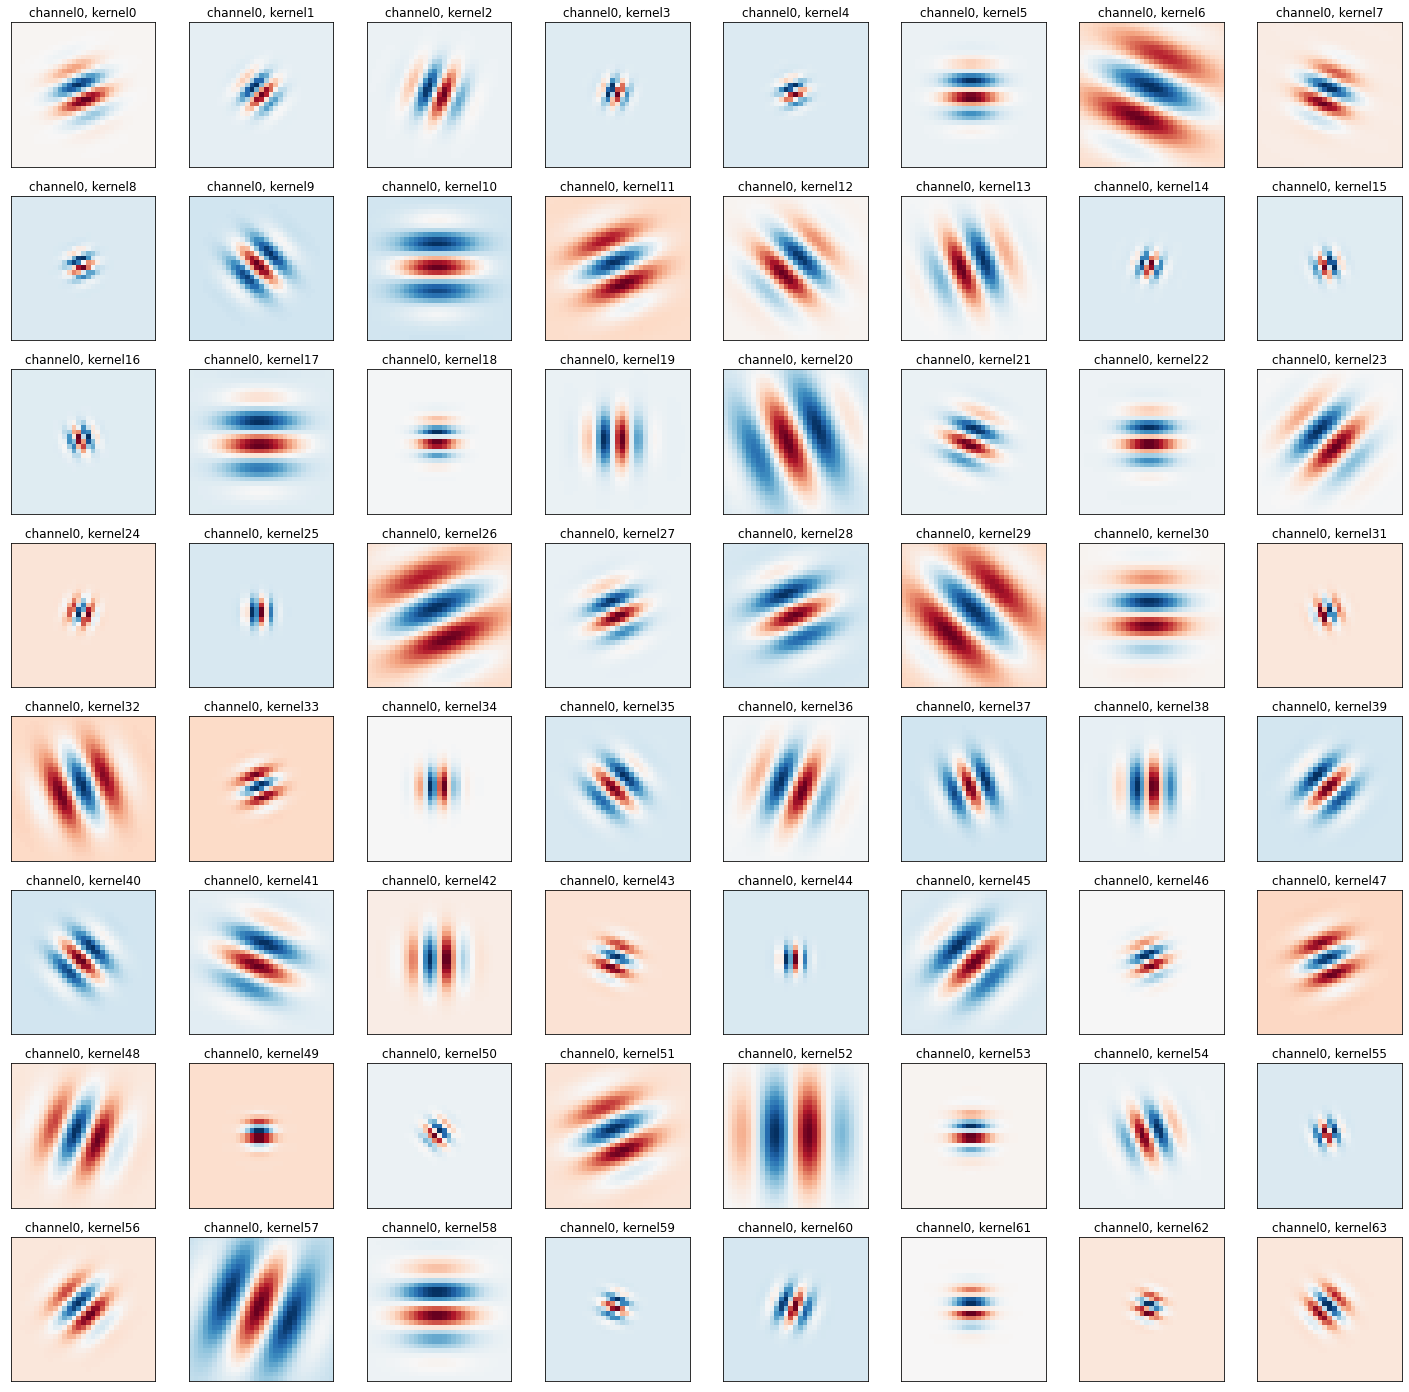

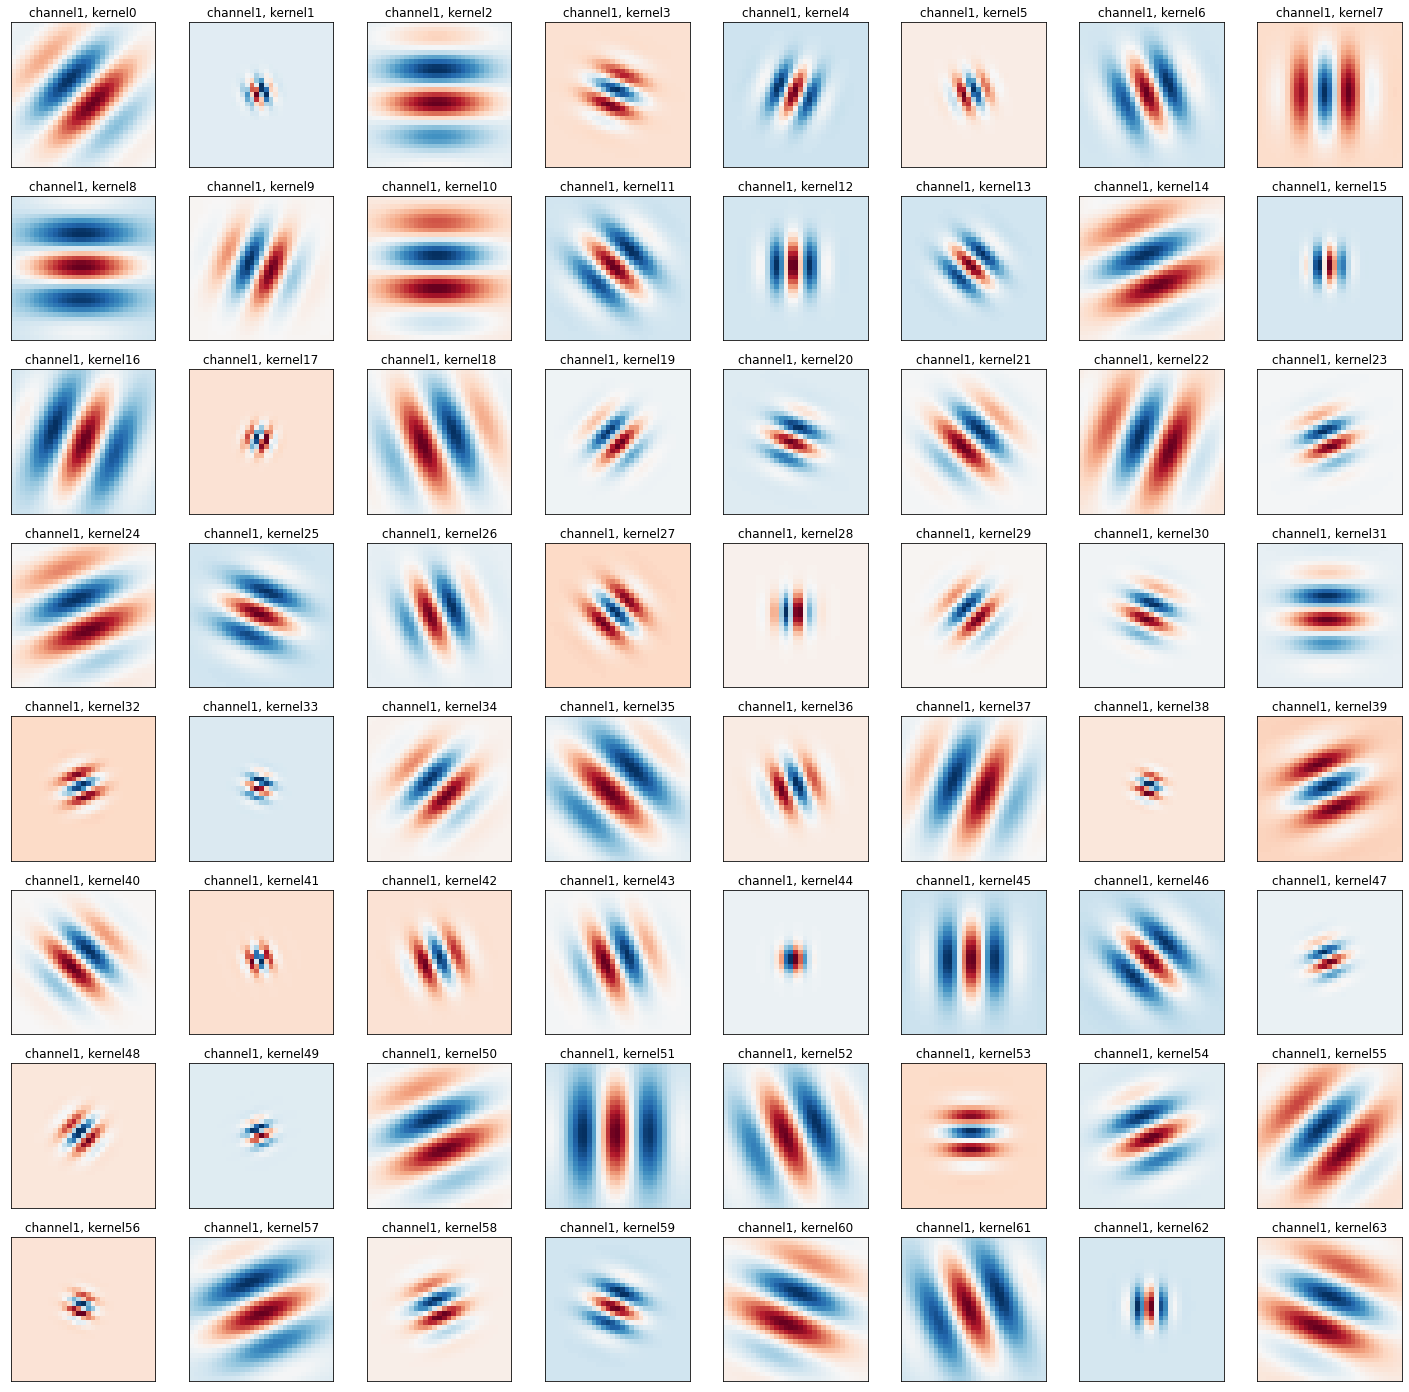

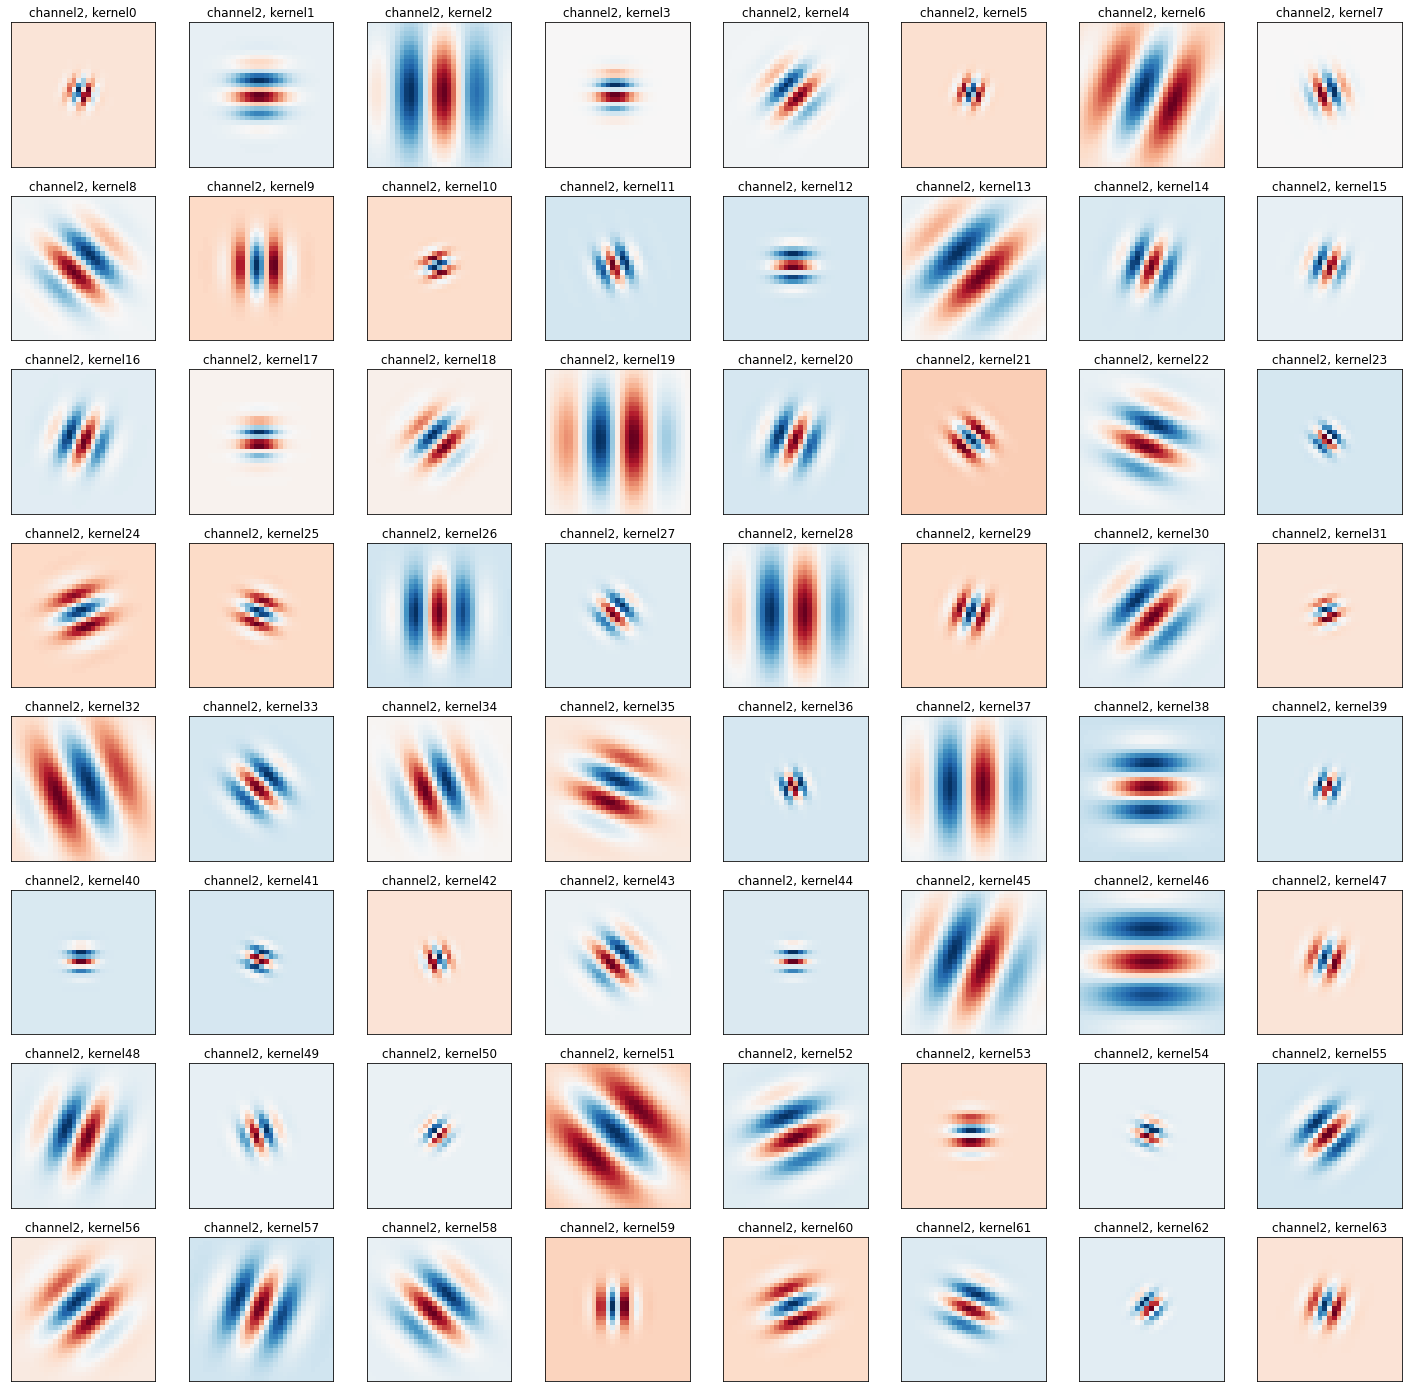

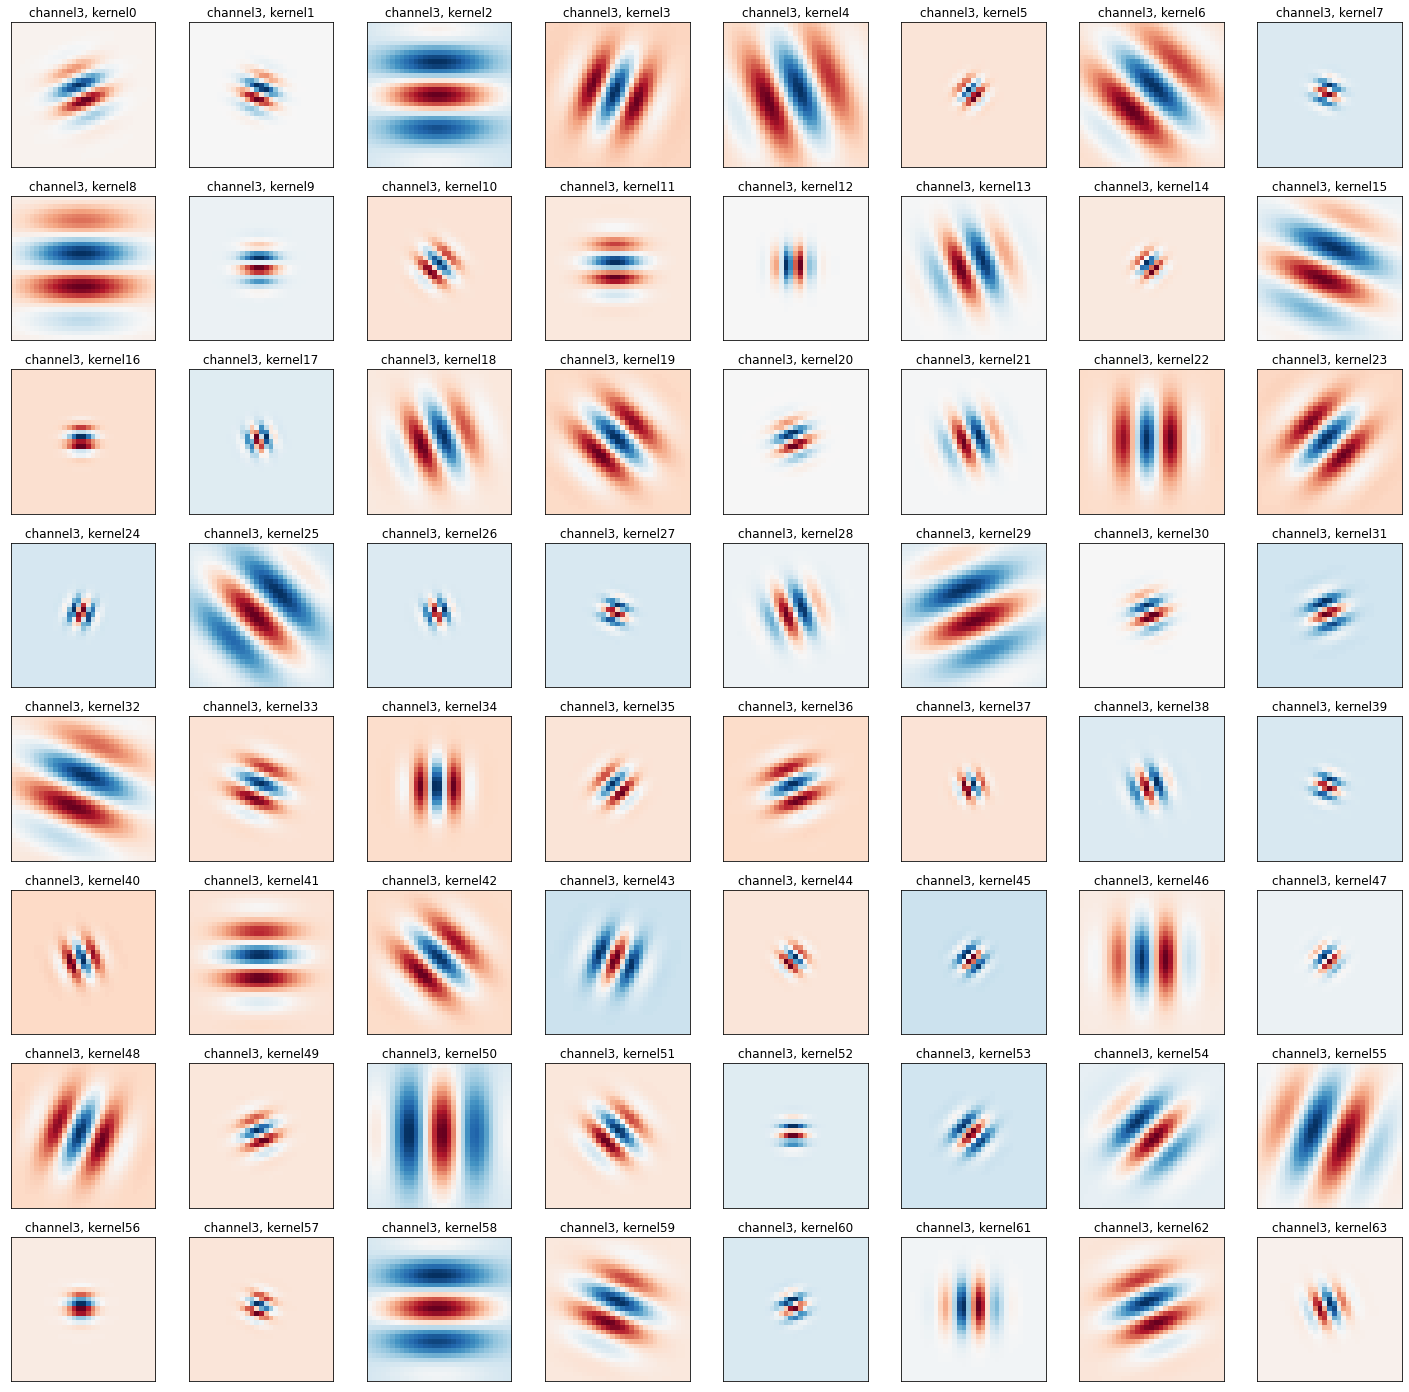

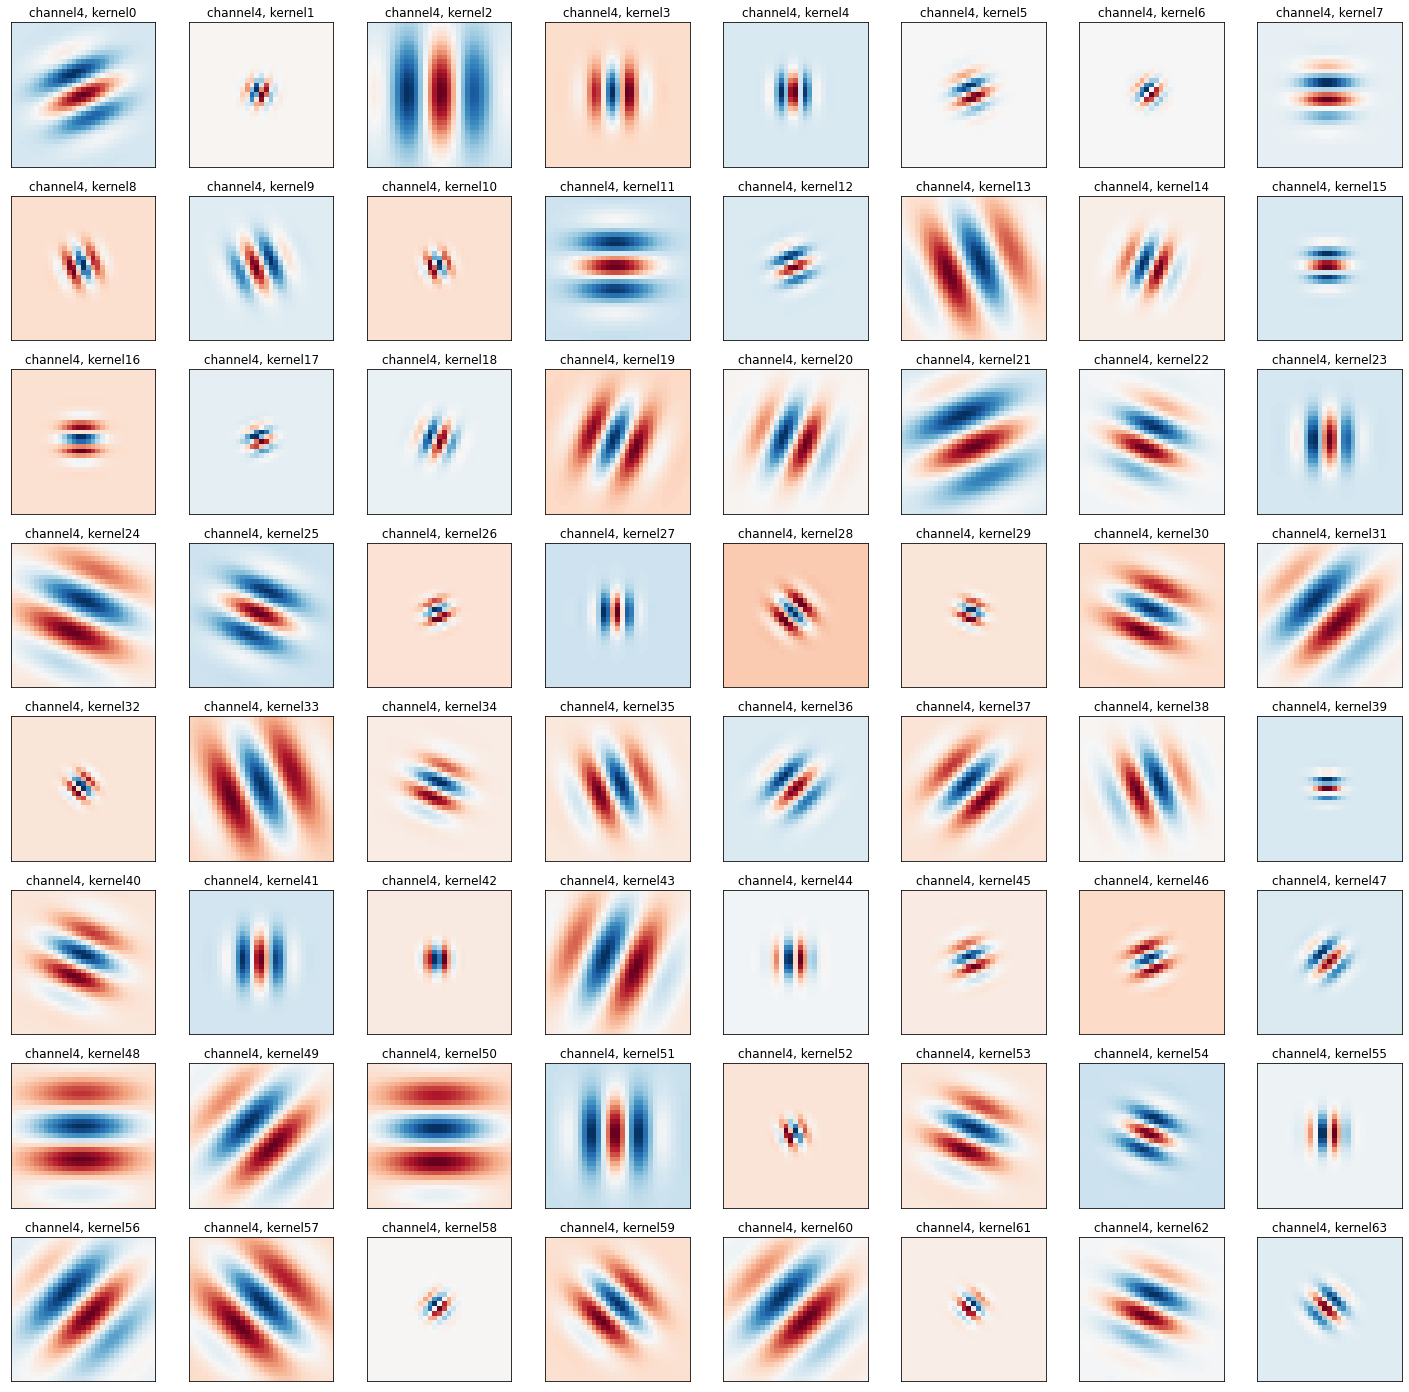

In [53]:


'''def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.detach().numpy(),(1,2,0))'''
    #plt.imshow(img,"gray")
for channel in np.arange(5):
  fig = plt.figure(figsize=(25,25))
  kernel=model.features[0].conv_layer.weight[:,channel,:,:]
  for idx in np.arange(64):    
      ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
      #print(kernel[idx].shape)
      #imshow(kernel[idx])
      plt.imshow(kernel[idx].detach().numpy(),plt.cm.get_cmap("RdBu"))
      ax.set_title("channel{}, kernel{}".format(channel,idx))

In [5]:
count=0
for name,parameters in model.named_parameters():
  if count<=20:
    #print(parameters)
    print(name, ":", parameters)
    
    count+=1

features.0.freq : Parameter containing:
tensor([[0.7854, 0.3927, 1.5708, 0.7854, 0.5554],
        [1.1107, 1.5708, 0.7854, 1.1107, 1.5708],
        [0.7854, 0.3927, 0.3927, 0.3927, 0.3927],
        [1.5708, 0.7854, 1.1107, 0.5554, 0.7854],
        [1.5708, 0.7854, 0.7854, 0.3927, 1.1107],
        [0.7854, 1.1107, 1.5708, 1.5708, 1.1107],
        [0.3927, 0.5554, 0.3927, 0.3927, 1.5708],
        [0.7854, 0.5554, 1.1107, 1.5708, 0.7854],
        [1.5708, 0.3927, 0.5554, 0.3927, 1.1107],
        [0.7854, 0.5554, 0.7854, 1.1107, 0.7854],
        [0.5554, 0.3927, 1.5708, 1.1107, 1.5708],
        [0.5554, 0.5554, 1.1107, 0.7854, 0.5554],
        [0.5554, 0.7854, 1.1107, 1.1107, 1.1107],
        [0.5554, 0.7854, 0.3927, 0.5554, 0.3927],
        [1.5708, 0.3927, 0.7854, 1.5708, 0.7854],
        [1.5708, 1.1107, 1.1107, 0.3927, 1.1107],
        [1.5708, 0.3927, 0.7854, 1.5708, 1.1107],
        [0.5554, 1.5708, 1.1107, 1.5708, 1.5708],
        [1.1107, 0.3927, 0.7854, 0.5554, 1.1107],
        [0

In [ ]:
testloader_list=[contours,contours_inverted,line_drawings,line_drawings_inverted,silhouettes,silhouettes_inverted]

test_str=["contours","contours_inverted","line_drawings","line_drawings_inverted","silhouettes","silhouettes_inverted"]

In [ ]:


def test_set(net,testloader_list,test_str):
    current=0
    for testloader in testloader_list:
      correct = 0   # 定义预测正确的图片数，初始化为0
      total = 0     # 总共参与测试的图片数，也初始化为0
      # testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
      torch.cuda.empty_cache()
      net.to(device)
      net.eval()
      with torch.no_grad():
          for data in testloader:  # 循环每一个batch
              images, labels = data
              images = images.to(device)
              labels = labels.to(device)
              net.eval()  # 把模型转为test模式
              if hasattr(torch.cuda, 'empty_cache'):
                  torch.cuda.empty_cache()
              outputs = net(images)  # 输入网络进行测试

              # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)          # 更新测试图片的数量
              correct += (predicted == labels).sum() # 更新正确分类的图片的数量

          print('Accuracy of the network on the '+test_str[current] +' test images: %.2f %%' % (100 * correct / total))
      current+=1

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_path = "./model/OpponencyEcoGaborResNet34.pth"
model = ResNet34().to(device)
model = torch.load(save_path)
model.eval()


Accuracy of the network on the contours test images: 13.00 %
Accuracy of the network on the contours_inverted test images: 13.00 %
Accuracy of the network on the line_drawings test images: 22.00 %
Accuracy of the network on the line_drawings_inverted test images: 15.00 %
Accuracy of the network on the silhouettes test images: 15.00 %
Accuracy of the network on the silhouettes_inverted test images: 10.00 %


In [ ]:
save_path = "./model/OpponencyCifarGaborResNet34.pth"
net2 = ResNet34()
net2 = torch.load(save_path)
net2.eval()
test_set(net2,testloader_list,test_str)

Accuracy of the network on the contours test images: 47.00 %
Accuracy of the network on the contours_inverted test images: 43.00 %
Accuracy of the network on the line_drawings test images: 67.00 %
Accuracy of the network on the line_drawings_inverted test images: 52.00 %
Accuracy of the network on the silhouettes test images: 57.00 %
Accuracy of the network on the silhouettes_inverted test images: 48.00 %


In [ ]:
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
loc="/content/drive/My Drive/Final2022/data/new224/contours/horse/horse001.png"
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
img=Image.open(loc)
img = transform(img)
img = img.unsqueeze(0) 
print(img.shape)
model.eval()
model(img)
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
pred_class = classes[predicted.item()]
print("分类",pred_class)

torch.Size([1, 3, 32, 32])
概率 tensor([[0.1400, 0.0085, 0.1478, 0.1396, 0.1519, 0.1550, 0.0222, 0.1393, 0.0587,
         0.0370]], grad_fn=<SoftmaxBackward0>)
类别 5
tensor([0.7486])
分类 dog


In [ ]:
testloader_list=[contours,contours_inverted,line_drawings,line_drawings_inverted,silhouettes,silhouettes_inverted]
test_str=["contours","contours_inverted","line_drawings","line_drawings_inverted","silhouettes","silhouettes_inverted"]
img_path=contours_="/content/drive/My Drive/Final2022/data/new224"
def test_all(img_path,model):
  classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  transform = transforms.Compose([
  #transforms.CenterCrop(224),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
  for type_file in os.listdir(img_path):
    
    ca_list=[]
    for new_c in os.listdir(img_path+"/"+type_file):
      correct=0
      ca=0
      for img_name in os.listdir(img_path+"/"+type_file+"/"+new_c):
        img = Image.open(img_path+"/"+type_file+"/"+new_c+"/"+img_name)
        img = transform(img)
        img = img.unsqueeze(0)
        model.eval()
        model(img)
        output = model(img)
        prob = F.softmax(output,dim=1) #prob是10个分类的概率
        value, predicted = torch.max(output.data, 1)
        if predicted.item()==ca:
          correct+=1
        ca+=1
      ca_rate=correct/10
      ca_list.append(ca_rate)
    print(type_file)
    print("acc_list: ",ca_list)
    print("total_acc: ",sum(ca_list)/10,"\n")
    
test_all(img_path,model)

contours_inverted
acc_list:  [0.0, 0.0, 0.2, 0.1, 0.1, 0.0, 0.1, 0.2, 0.2, 0.0]
total_acc:  0.09 

silhouettes_inverted
acc_list:  [0.0, 0.2, 0.2, 0.1, 0.2, 0.1, 0.1, 0.0, 0.1, 0.1]
total_acc:  0.10999999999999999 

silhouettes
acc_list:  [0.1, 0.1, 0.1, 0.2, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1]
total_acc:  0.12 

line_drawings_inverted
acc_list:  [0.0, 0.2, 0.0, 0.0, 0.3, 0.0, 0.3, 0.0, 0.3, 0.0]
total_acc:  0.11000000000000001 

contours
acc_list:  [0.1, 0.2, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
total_acc:  0.12000000000000002 

line_drawings
acc_list:  [0.0, 0.2, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1]
total_acc:  0.11000000000000001 



In [58]:
save_path = "./model/OpponencyCifarGaborResNet34.pth"

net2 = ResNet34()
net2 = torch.load(save_path)
net2.eval()
test_all(img_path,net2)

NameError: ignored

In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

'''cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}'''

class GaborConv2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=False,
        padding_mode="zeros",
    ):
        super().__init__()

        self.is_calculated = False

        self.conv_layer = nn.modules.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
        )
        self.kernel_size = self.conv_layer.kernel_size

        # small addition to avoid division by zero
        self.delta = 1e-3

        # freq, theta, sigma are set up according to S. Meshgini,
        # A. Aghagolzadeh and H. Seyedarabi, "Face recognition using
        # Gabor filter bank, kernel principal component analysis
        # and support vector machine"
        self.freq = nn.Parameter((math.pi / 2) * math.sqrt(2) ** (-torch.randint(0, 5, (out_channels, in_channels))).type(torch.Tensor),requires_grad=True, )
        self.theta = nn.Parameter((math.pi / 8) * torch.randint(0, 8, (out_channels, in_channels)).type(torch.Tensor),requires_grad=True,)
        self.sigma = nn.Parameter(math.pi / self.freq, requires_grad=True)
        self.psi = nn.Parameter(math.pi * torch.rand(out_channels, in_channels), requires_grad=True)
        self.x0 = nn.Parameter(torch.ceil(torch.Tensor([self.kernel_size[0] / 2]))[0], requires_grad=False)
        self.y0 = nn.Parameter(torch.ceil(torch.Tensor([self.kernel_size[1] / 2]))[0], requires_grad=False)
        self.y, self.x = torch.meshgrid(
            [torch.linspace(-self.x0 + 1, self.x0 + 0, self.kernel_size[0]),
             torch.linspace(-self.y0 + 1, self.y0 + 0, self.kernel_size[1]),])
        self.y = nn.Parameter(self.y)
        self.x = nn.Parameter(self.x)
        self.weight = nn.Parameter(torch.empty(self.conv_layer.weight.shape, requires_grad=True),requires_grad=True,)


        self.register_parameter("freq", self.freq)
        self.register_parameter("theta", self.theta)
        self.register_parameter("sigma", self.sigma)
        self.register_parameter("psi", self.psi)
        self.register_parameter("x_shape", self.x0)
        self.register_parameter("y_shape", self.y0)
        self.register_parameter("y_grid", self.y)
        self.register_parameter("x_grid", self.x)
        self.register_parameter("weight", self.weight)

    def forward(self, input_tensor):
        if self.training:
            self.calculate_weights()
            #print(self.conv_layer.weight.data.shape)
            self.is_calculated = False
        if not self.training:
            if not self.is_calculated:
                self.calculate_weights()
                self.is_calculated = True
        return self.conv_layer(input_tensor)

    def calculate_weights(self):
        for i in range(self.conv_layer.out_channels):
            for j in range(self.conv_layer.in_channels):
                sigma = self.sigma[i, j].expand_as(self.y)
                freq = self.freq[i, j].expand_as(self.y)
                theta = self.theta[i, j].expand_as(self.y)
                psi = self.psi[i, j].expand_as(self.y)

                rotx = self.x * torch.cos(theta) + self.y * torch.sin(theta)
                roty = -self.x * torch.sin(theta) + self.y * torch.cos(theta)

                g = torch.exp(-0.5 * ((rotx ** 2 + roty ** 2) / (sigma + self.delta) ** 2))
                g = g * torch.cos(freq * rotx + psi)
                g = g / (2 * math.pi * sigma ** 2)
                self.conv_layer.weight.data[i, j] = g

class GaborConvFixed(nn.Module):
    def __init__(self,
          in_channels,
          out_channels,
          input_dict,
          kernel_size,
          stride=1,
          padding=0,
          dilation=1,
          groups=1,
          bias=False,
          padding_mode="zeros",
          ):
      super().__init__()
      self.input_dict=input_dict
      if self.input_dict==None:
          self.input_dict = {  # 'ksize': (127, 127),
            'ksize': (31, 31),
            'gammas': [0.5],
            #           'bs': np.linspace(0.4, 2.6, num=3),  # 0.4, 1, 1.8, 2.6
            #           'bs': np.linspace(0.4, 2.6, num=5),
            'bs': np.linspace(1, 2.6, num=3).tolist(),
            #           'bs': np.linspace(1, 2.6, num=5),
            #           'sigmas': [4, 8, 16],  # , 32
            'sigmas': [8],
            'thetas': np.linspace(0, np.pi, 4, endpoint=False).tolist(),
            'psis': [np.pi / 2, 3 * np.pi / 2]}
      
      self.ksize = self.input_dict["ksize"]
      self.sigmas = self.input_dict["sigmas"]
      self.bs = self.input_dict["bs"]
      self.gammas = self.input_dict["gammas"]
      self.thetas = self.input_dict["thetas"]
      self.psis = self.input_dict["psis"]

      self.conv_layer = nn.modules.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
        )
      
      self.weight = nn.Parameter(torch.empty(self.conv_layer.weight.shape, requires_grad=False),requires_grad=False,)

    def calc_lambda(self, sigma, bandwidth):
      p = 2**bandwidth
      c = np.sqrt(np.log(2)/2)
      return sigma * np.pi / c  * (p - 1) / (p + 1)
    
    def forward(self, input_tensor):
      self.calculate_weights()
      return self.conv_layer(input_tensor)
    
    def calculate_weights(self):
      for i in range(self.conv_layer.out_channels):
          for j in range(self.conv_layer.in_channels):
              for sigma in self.sigmas:
                for theta in self.thetas:
                    # for lambd in lambdas:
                    for b in self.bs:
                        lambd = self.calc_lambda(sigma, b)
                        for gamma in self.gammas:
                            for psi in self.psis:
                                gf = cv2.getGaborKernel(self.ksize, sigma, theta,lambd, gamma, psi, ktype=cv2.CV_64F)
                                self.conv_layer.weight.data[i, j] = torch.tensor(gf)

class VGG(nn.Module):
    
    def __init__(self, vgg_name, param=None):
        super(VGG, self).__init__()
        self.param=param
        self.Gabor_out_channels=64
        '''if param:
          self.g0=GaborConvFixed(in_channels=3, out_channels= 24, input_dict=self.param,kernel_size=(31, 31) ,padding=15)
        else:'''
        self.g0=GaborConv2d(in_channels=5, out_channels= self.Gabor_out_channels, kernel_size=(31, 31),padding=15)
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,10),
        )
#         self.classifier = nn.Linear(512,10)

        self._initialize_weight()
        
    def forward(self, x):
      x=self.opponency_encoder(x)
      out = self.features(self.g0(x))
      # 在进入
      out = out.view(out.size(0), -1)
      #out = self.classifier(out)
      return out
    def opponency_encoder(self,data_tensor):
      num, channel, row, col=data_tensor.shape
      inputshape=(num,int(channel/3),row,col)
      r = data_tensor[:, 0, :, :]
      g = data_tensor[:, 1, :, :]
      b = data_tensor[:, 2, :, :]
      I = ((r + g + b) / 3).reshape(inputshape)
      R = torch.clamp(r - (g + b) / 2,min=0.0)
      G = torch.clamp(g - (r - b) / 2,min=0.0)
      B = torch.clamp(b - (r + g) / 2,min=0.0)
      Y = torch.clamp((r + g) / 2 - (r - g) / 2 - b,min=0.0)
      RG = torch.clamp(R - G,min=0.0).reshape(inputshape)
      GR = torch.clamp(G - R,min=0.0).reshape(inputshape)
      BY = torch.clamp(B - Y,min=0.0).reshape(inputshape)
      YB = torch.clamp(Y - B,min=0.0).reshape(inputshape)
      return torch.cat((I,RG,GR,BY,YB),1)
    # make layers

    def _make_layers(self, cfg):
        layers = []
        in_channels = self.Gabor_out_channels # RGB 初始通道为3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] # kernel_size 为 2 x 2,然后步长为2
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # 都是(3.3)的卷积核
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]  # RelU
                in_channels = x  # 重定义通道
#         layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    # 初始化参数
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # xavier is used in VGG's paper
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_path = "./model/OpponencyEcoGaborVGG16.pth"
model = VGG('VGG16')
model = torch.load(save_path)
model.eval()

DataParallel(
  (module): VGG(
    (g0): GaborConv2d(
      (conv_layer): Conv2d(5, 64, kernel_size=(31, 31), stride=(1, 1), padding=(15, 15), bias=False)
    )
    (features): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=

In [ ]:
test_set(model,testloader_list,test_str)

Accuracy of the network on the contours test images: 35.00 %
Accuracy of the network on the contours_inverted test images: 40.00 %
Accuracy of the network on the line_drawings test images: 50.00 %
Accuracy of the network on the line_drawings_inverted test images: 38.00 %
Accuracy of the network on the silhouettes test images: 45.00 %
Accuracy of the network on the silhouettes_inverted test images: 25.00 %


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_path = "./model/OpponencyCifarGaborVGG16.pth"
model = VGG('VGG16')
model = torch.load(save_path)
model.eval()
test_set(model,testloader_list,test_str)

Accuracy of the network on the contours test images: 43.00 %
Accuracy of the network on the contours_inverted test images: 48.00 %
Accuracy of the network on the line_drawings test images: 64.00 %
Accuracy of the network on the line_drawings_inverted test images: 53.00 %
Accuracy of the network on the silhouettes test images: 52.00 %
Accuracy of the network on the silhouettes_inverted test images: 48.00 %
